In [36]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

from keras.models import Sequential
from keras.layers import LSTM, Dense

import tensorflow as tf

In [19]:
df = pd.read_csv('/content/Friday-WorkingHours-Morning.pcap_ISCX.csv')
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3268,112740690,32,16,6448,1152,403,0,201.5,204.724205,...,32,3.594286e+02,1.199802e+01,380,343,16100000.0,4.988048e+05,16400000,15400000,BENIGN
1,389,112740560,32,16,6448,5056,403,0,201.5,204.724205,...,32,3.202857e+02,1.574499e+01,330,285,16100000.0,4.987937e+05,16400000,15400000,BENIGN
2,0,113757377,545,0,0,0,0,0,0.0,0.000000,...,0,9.361829e+06,7.324646e+06,18900000,19,12200000.0,6.935824e+06,20800000,5504997,BENIGN
3,5355,100126,22,0,616,0,28,28,28.0,0.000000,...,32,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,0,54760,4,0,0,0,0,0,0.0,0.000000,...,0,0.000000e+00,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


In [20]:
len(df)

191033

In [21]:
df.columns = df.columns.str.strip()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [22]:
len(df)

190911

In [23]:
df_experiment = df[df['Label'].str.contains('DoS|BENIGN', na=False)]
df_experiment = df_experiment[df_experiment['Label'] != 'DoS Slowhttptest']

In [24]:
len(df_experiment)

188955

In [25]:
df.Label.value_counts()

,count
Label,
BENIGN,188955
Bot,1956


In [26]:
df_experiment = df.copy()
df_experiment['Label'] = df_experiment['Label'].replace("Web.*", "Web Attack", regex=True)
df_experiment['Label'] = df_experiment['Label'].replace(r'.*Patator$', "Brute Force", regex=True)
df_experiment['Label'] = df_experiment['Label'].replace(["DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris"], "DoS")
df_experiment.Label.value_counts()

,count
Label,
BENIGN,188955
Bot,1956


In [27]:
class_attack = ['PortScan', 'Web Attack', 'Brute Force', 'DDoS', 'Bot','Infiltration', 'DoS', 'Heartbleed']
df_experiment['Label'] = np.where(df_experiment['Label'].isin(class_attack), 1, 0)

In [28]:
df_experiment['Label'].value_counts()

,count
Label,
0,188955
1,1956


In [29]:
X = df_experiment.drop(columns=['Label'])
y = df_experiment['Label']

In [38]:
print(X.shape)
print("instances per label\n", y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

print("after spliting the data:\n")
print("training data length:", len(X_train))
print("test data length:", len(X_test))


(190911, 78)
instances per label
 Label
0    188955
1      1956
Name: count, dtype: int64
after spliting the data:

training data length: 152728
test data length: 38183


In [31]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(f"shape of X_train:", X_train_lstm.shape)
print(f"shape of X_test:", X_test_lstm.shape)

shape of X_train: (152728, 1, 78)
shape of X_test: (38183, 1, 78)


In [33]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
es = tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss", restore_best_weights=True)

history = lstm_model.fit(X_train_lstm,
                         y_train,
                         epochs=5,
                         validation_data=(X_test_lstm, y_test),
                         batch_size=32,
                         callbacks = [])

Epoch 1/5
4773/4773 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9952 - loss: 0.0160 - val_accuracy: 0.9959 - val_loss: 0.0162
Epoch 2/5
4773/4773 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.9959 - loss: 0.0152 - val_accuracy: 0.9961 - val_loss: 0.0149
Epoch 3/5
4773/4773 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - accuracy: 0.9960 - loss: 0.0142 - val_accuracy: 0.9961 - val_loss: 0.0142
Epoch 4/5
4773/4773 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.9958 - loss: 0.0152 - val_accuracy: 0.9961 - val_loss: 0.0148
Epoch 5/5
4773/4773 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.9963 - loss: 0.0130 - val_accuracy: 0.9959 - val_loss: 0.0155


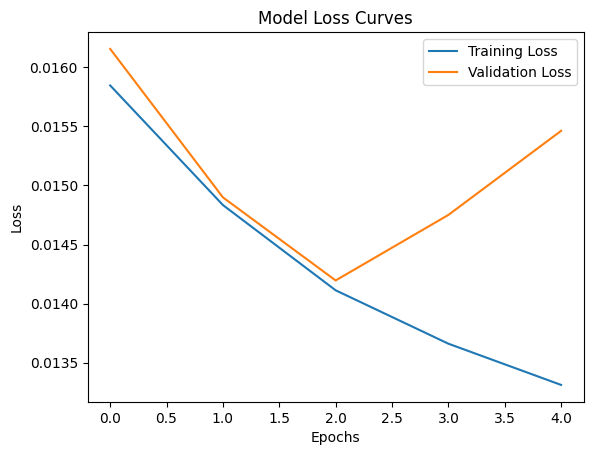

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [43]:
lstm_model.evaluate(X_test_lstm, y_test)

1194/1194 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9962 - loss: 0.0144


[0.015461965464055538, 0.9959143996238708]

In [44]:
def predict_intrusion(user_input, scaler, model):
    try:
        user_input = np.array(user_input).reshape(1, -1)
        user_input_scaled = scaler.transform(user_input)
        user_input_scaled_lstm = user_input_scaled.reshape(1, 1, user_input_scaled.shape[1])
        prediction = model.predict(user_input_scaled_lstm)
        if prediction[0][0] >= 0.5:
            print("Intrusion occurred!")
        else:
            print("No intrusion detected.")
    except Exception as e:
        print(f"Error: {e}")

In [47]:
example_input = [0.2] * 78
predict_intrusion(example_input, scaler, lstm_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
No intrusion detected.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
